In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

env: CUDA_VISIBLE_DEVICES=0


device(type='cuda')

### Setup

In [2]:
data_name = 'GAS'
model = 'GLOW'

num_layers = 5
num_epoch = 20000
if model == 'SPLINE-AR':
    num_epoch = 10000

model_name = f"{model}_{num_layers}"

model_save_dir = f'../models/{data_name}/{model_name}/'
os.makedirs(f'{model_save_dir}/checkpoints', exist_ok=True)


### Data

In [3]:
from utils import data_utils

data_mapping = {'BSDS300': data_utils.BSDS300,
                'GAS': data_utils.GAS,
                'MINIBOONE': data_utils.MINIBOONE,
                'POWER': data_utils.POWER,
                'HEPMASS': data_utils.HEPMASS}
data = data_mapping[data_name]()

dim = data.n_dims


In [4]:
X_train_tensor = torch.from_numpy(data.trn.x)
X_test_tensor = torch.from_numpy(data.tst.x)

In [5]:
from torch.distributions import MultivariateNormal

prior = MultivariateNormal(torch.zeros(data.n_dims).to(device),
                           torch.eye(data.n_dims).to(device))


In [6]:
from src.mrartemev_nflib.flows import NormalizingFlowModel, InvertiblePermutation, Invertible1x1Conv, ActNorm, NSF_AR
from src.mrartemev_nflib.flows import MAF, AffineHalfFlow
from src.mrartemev_nflib.nn import ARMLP, MLP


flows = []
for _ in range(num_layers):
    if model == 'MAF':
        flows.append(MAF(dim=data.n_dims, base_network=ARMLP))
        flows.append(InvertiblePermutation(dim=data.n_dims))
    if model == 'SPLINE-AR':
        flows.append(ActNorm(dim=data.n_dims))
        flows.append(Invertible1x1Conv(dim=data.n_dims))
        flows.append(NSF_AR(dim=data.n_dims, K=8, B=3, hidden_features=32, depth=1, base_network=MLP))
    if model == 'GLOW':
        flows.append(ActNorm(dim=data.n_dims))
        flows.append(Invertible1x1Conv(dim=data.n_dims))
        flows.append(AffineHalfFlow(dim=data.n_dims, hidden_features=32, base_network=MLP))
        flows.append(InvertiblePermutation(dim=data.n_dims))
    if model == 'RealNVP':
        flows.append(AffineHalfFlow(dim=data.ndims))
        flows.append(InvertiblePermutation(dim=data.n_dims))

lr = 0.0001
if model == 'SPLINE-AR':
    lr *= 10
        
model = NormalizingFlowModel(prior, flows).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
def to_device(model, device):
    model.to(device)
    model.prior = MultivariateNormal(torch.zeros(data.n_dims).to(device),
                                     torch.eye(data.n_dims).to(device))

to_device(model, device)

In [8]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

dloader = DataLoader(TensorDataset(X_train_tensor), batch_size=2**12,
                     shuffle=True, drop_last=True, num_workers=6)
test_dloader = DataLoader(TensorDataset(X_test_tensor), batch_size=2**12,
                          shuffle=True, drop_last=True, num_workers=6)


In [9]:
from IPython.display import clear_output
from tqdm import tqdm


plot_freq = 1500

epoch_losses = []
train_losses = []

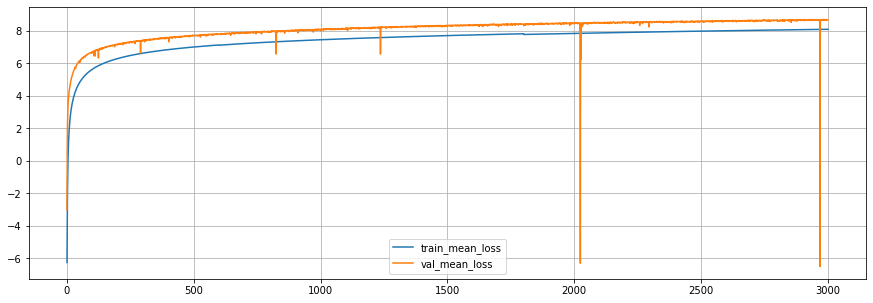

 18%|█▊        | 3573/20000 [10:11:01<46:44:19, 10.24s/it]

In [ ]:
for epoch in tqdm(range(len(epoch_losses), num_epoch), position=0):
    for ind, batch in enumerate(dloader):
        model.train()
        
        # fit
        optimizer.zero_grad()
        logp_x = model.log_prob(batch[0].to(device))
        loss = -torch.mean(logp_x)
        loss.backward()
        
        # clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                
        # step
        optimizer.step()

        # log
        train_losses.append(-loss.item())

    # eval
    with torch.no_grad():
        model.eval()
        logp_x = np.mean([torch.mean(model.log_prob(batch[0].to(device))).item() for batch in test_dloader])
        epoch_losses.append([np.mean(train_losses), logp_x])
    
    # show
    if epoch % plot_freq == 0 and epoch != 0:        
        clear_output(True)
        plt.figure(figsize=(15, 5))
        val_losses = np.array(epoch_losses)
        plt.plot(val_losses[:, 0], label='train_mean_loss')
        plt.plot(val_losses[:, 1], label='val_mean_loss')
        plt.grid()
        plt.legend()
        plt.show()
        
    # checkpoint
    if epoch % plot_freq == 0 and epoch != 0:        
        torch.save(model.state_dict(),
                   os.path.join(model_save_dir, 'checkpoints', f'{epoch}_model.state_dict'))
        torch.save(optimizer.state_dict(),
                   os.path.join(model_save_dir, 'checkpoints', f'{epoch}_optimizer.state_dict'))
        

        

In [ ]:
torch.save(model.state_dict(), os.path.join(model_save_dir, 'model.state_dict'))
torch.save(optimizer.state_dict(), os.path.join(model_save_dir, 'optimizer.state_dict'))


In [ ]:
# model.load_state_dict(torch.load(os.path.join(model_save_dir, 'model.state_dict')))

### Model eval

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from src.nf import CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf
from scipy.special import logsumexp


In [ ]:
model.eval()
model.sample_n = lambda x: model.sample(x)

to_device(model, 'cpu')

In [ ]:
n = min(100000, X_test_tensor.shape[0])

print('Model test LL ', torch.mean(model.log_prob(X_test_tensor[:n])).item())

clf_ds_train = np.row_stack([
    np.column_stack([X_train_tensor[:n].detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample(n).detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_ds_test = np.row_stack([
    np.column_stack([X_test_tensor[:n].detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample(n).detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

In [ ]:
clf = CatBoostClassifier(
    5000, eval_metric='AUC',
    metric_period=1000,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

In [ ]:
calibrated_model = CalibratedModel(clf, model, logit=True)

samples = model.sample(n).detach().cpu().numpy()
clf_preds = clf.predict(samples, prediction_type='RawFormulaVal')
calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))

-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model, X_test_tensor) - calibration_constant,